### Tamagotchi MDP
pam o.p. 2018
Not a real tamagotchi, but a simple version of one

In [1]:
# imports
from random import randint
import numpy as np
import random
import datetime # for limiting calculation to wall clock time
from math import log, sqrt
import copy

In [56]:
# tamagotchi class adapted from https://github.com/bitterfly/tamagotchi/blob/master/tamagotchi/core/tamagotchi.py

class Tamagotchi:
    def __init__(self):
        self.stats = {"food": 100, "happiness": 100, "hygiene": 100,
                 "health": 100, "energy": 100}
        self.is_sleeping = False
        self.is_dead = False
        self.is_playing = False
        self.is_sick = False
        self.number_of_poo = 0
        self.money = 0
        self.time = 0
        self.in_store = False

    #Makes sure the statistic isn't below 0 or above 100
    def constrain(self, value):
        value = min(100, value)
        value = max(0, value)
        return value

    #Constrains all the stats
    def constrain_stats(self):
        for statistic, value in self.stats.items():
            self.stats[statistic] = self.constrain(value)

    #Takes a dictionary with statistics and adds each value
    #to the tamagotchi statistics
    def apply(self, item):
#         for statistic, value in self.stats.items():
#             self.stats[statistic] += item[statistic]
        self.stats[item['stats']] += item['effect']
        self.constrain_stats()

#     #Takes a statistic and decreases it to zero in "full hours" time
    def decrease_to_minimum(self, statistic, full_hours, time_given):
        self.stats[statistic] -= 2 * np.ceil( (time_given * 10) / (full_hours * 36) ) 
#     def decrease_to_minimum(self, statistic, full_hours, time_given):
#         self.stats[statistic] -= int(full_hours/2)

#     #Takes a statistic and increases it to max in "full hours" time
    def increase_to_maximum(self, statistic, full_hours, time_given):
        self.stats[statistic] += 2 * np.ceil( (time_given * 10) / (full_hours * 36) ) 
#     def increase_to_maximum(self, statistic, full_hours, time_given):
#         self.stats[statistic] += int(full_hours)

    #Generates random sickness and poo
    def random_event(self):
        if (not self.is_playing and not self.is_sleeping):
            random_number = randint(0, 600)
            if random_number == 0:
                self.is_sick = True
            if random_number == 1:
                self.number_of_poo = min (self.number_of_poo + 1, 4)

    #Used in mainwindow - removes sickness
    def cure(self):
        self.is_sick = False

    #The function witch decreases all the stats every second
    #or is called when tamagotchi is sleeping
    def second_pass(self, seconds=1):
        "Докато спиш всички статове падат за 8 часа, освен сънят, който се възстановява"
        "As long as you sleep, all the stats fall for 8 hours, except for the sleep that is recovering"
        self.time += 1 
        
        if self.is_sleeping:
            self.increase_to_maximum("energy", 3, seconds)
            self.decrease_to_minimum("happiness", 20, seconds)
            self.decrease_to_minimum("hygiene", (20 + 2*self.number_of_poo), seconds)
            self.decrease_to_minimum("food", 20, seconds)
            
            # earn money while asleep
            if self.is_playing:
                self.money += 4*seconds # pam added
            
            if self.stats["energy"] > 50:
                self.is_sleeping = False
        else:
            "Докато играеш, повечето статистики падат по-бързо."
            "As you play, most stats fall faster"
            if self.is_playing:
                self.decrease_to_minimum("energy", 3, seconds)
                self.decrease_to_minimum("hygiene", 3, seconds)
                self.decrease_to_minimum("food", 6, seconds)
                self.increase_to_maximum("happiness", 1, seconds)
                self.money += 4*seconds # pam added
            else:
                self.decrease_to_minimum("energy", 4, seconds)
                self.decrease_to_minimum("hygiene", 4 / (self.number_of_poo + 1), seconds)
                self.decrease_to_minimum("food", 8, seconds)
                self.decrease_to_minimum("happiness", 4, seconds)

        if (self.stats["happiness"] <= 50 or
               self.stats["hygiene"] <= 50):
                self.is_sick = True
                
        if self.is_sick:
            self.decrease_to_minimum("health", 3, seconds)

        self.constrain_stats()

        self.random_event()

        if (self.stats["food"] == 0 or self.stats["health"] == 0):
            self.is_dead = True
        
        #add (?) that if energy is <=20 then goes to sleep
        if self.stats["energy"] <=20:
            self.is_sleeping = True

    #The function is called when an item is chosen and
    #applies its statistics
    def buy_item(self, item):
        self.apply(item)
        self.money -= item["price"]
        return self
    
    # so that tuple(tamagotchi) can be called, make tamagotchi iterable
    def __iter__(self):
        traits = [tuple(self.stats.items()),
                 self.is_sleeping,
                 self.is_dead,
                 self.is_playing,
                 self.is_sick,
                 self.number_of_poo,
                 self.money,
                 self.time,
                 self.in_store]
        for i in range(len(traits)):
            yield traits[i]
                
    
    def print_tama(self):
        print("Time:",self.time," seconds elapsed")
        if self.is_dead:
            print("Tama is dead!")
    
        print("TAMA STATS: ", self.stats)
        if self.is_sleeping:
            print("Tama is asleep.")
        else:
            print("Tama is awake.")
            if self.is_playing:
                print("Tama is playing.")
            if self.is_sick:
                print("Tama is sick.")
        print("Number of poo:",self.number_of_poo)
        print("Money:",self.money)
        if self.in_store:
            print("You're in the store, so you can buy an item if you want.")
        else:
            print("You're not in the store, so you can play, do nothing, or travel to the store.")
                
        print("\n")
        
    

In [22]:
# # game class
# # gaining money to buy items in store can be simple time cost/money reward exchange
# # agent decides when to gain money, and then which items to buy/apply to tamagotchi
class Tamagotchi_Game():
    def __init__(self):
#         self.tamagotchi = tamagotchi
        self.time_passing = True
    
    # start game 
#     def start(self,state):
#         self.time_passing = True
#         return state
        
    # not used, but would be useful for a human playing the game to take breaks
#     def pause(self):
#         self.time_passing = False
#         return self.tamagotchi
        
    # given a tuple tamagotchi "state" and action "action", what would the next tama state be?
    def next_state(self, tupstate, action):
        state = self.unpack(tupstate)
        
        if state.in_store:
            state.is_playing = False
            state.second_pass() # does this need to be state.second_pass()

            if action == 'nothing':
                state.in_store = False
                return tuple(state)
            elif action == 'coffee':
                return tuple(state.buy_item({"stats":"energy","price":3,"effect":8}))
            elif action == 'snack':
                return tuple(state.buy_item({"stats":"food","price":3,"effect":8}))
            elif action == 'clean':
                state.number_of_poo =0
                return tuple(state.buy_item({"stats":"hygiene","price":5,"effect":10}))
            elif action == 'medicine':
                state.cure()
                return tuple(state.buy_item({"stats":"health","price":8,"effect":15}))
            else:
                raise Exception('Invalid action while in store')

        if action == 'play':
            state.is_playing = True
            state.second_pass()
            # if the tama is sleeping, playing won't earn any money - tama needs to be awake
            return tuple(state)

        # "walk" to the store (takes one turn)
        if action == 'store':
            state.is_playing = False
            state.in_store = True
            state.second_pass()
            return tuple(state)

        if action == 'nothing':
            state.is_playing = False
            state.second_pass()
            return tuple(state)
       

        
    # Take a sequence of game states representing the full game history, and return the full list
    # of actions that are legal actions
    def legal_actions(self, state_history): 
        # this method is important for MDPs/games where the actions might change based on the game state
        # for instance, in checkers, if player put a piece on square A4, no other piece can move to A4
        
        # get object version of most recent tamagotchi state
        tama = self.unpack(state_history[-1])

        if not tama.is_dead:
            if tama.in_store:
                if tama.money >= 8:
                    return ['coffee','snack','clean','medicine','nothing']
                elif tama.money >= 5:
                    return ['coffee','snack','clean','nothing']
                elif tama.money >= 3:
                    return ['coffee','snack','nothing']
                else: # too poor to shop :(
                    return ['nothing']
            else: 
                return ['play','store','nothing']
        else:
            return []
    
    # Should this be the length of state_history (how long tama alive for)? or is it trial by trial rwd?
    def reward(self, state_history):
        tupletama = state_history[-1]
        
        done = False
        if tupletama[2]: # tama dead
            reward = tupletama[7] # you killed the tama :'( enjoy your MONEY
            done = True
        else:
            # reward is how long you kept the tama alive
            reward = tupletama[7] 

        return reward, done
    
    def unpack(self,tupletama):
        tama = Tamagotchi()
        tama.stats = dict(tupletama[0])
        tama.is_sleeping = tupletama[1]
        tama.is_dead = tupletama[2]
        tama.is_playing = tupletama[3]
        tama.is_sick = tupletama[4]
        tama.number_of_poo = tupletama[5]
        tama.money = tupletama[6]
        tama.time = tupletama[7]
        tama.in_store = tupletama[8]
        return tama

    

In [28]:
# Double check that the tama works - if we manually take actions, do we end up where expected? 
# Then we will create the MCTS solver so that a robot can choose actions instead of us.

tama = Tamagotchi()
tama.print_tama()
game = Tamagotchi_Game()

s = game.next_state(tuple(tama),'play')
s = game.next_state(s,'play')
s = game.next_state(s,'play')
s = game.next_state(s,'play')
s = game.next_state(s,'store')
tama = game.unpack(s)
tama.print_tama()

game.reward([s])

Time: 0  seconds elapsed
TAMA STATS:  {'happiness': 100, 'health': 100, 'food': 100, 'energy': 100, 'hygiene': 100}
Tama is awake.
Number of poo: 0
Money: 0
You're not in the store, so you can play, do nothing, or travel to the store.


Time: 5  seconds elapsed
TAMA STATS:  {'happiness': 98.0, 'health': 100, 'food': 90.0, 'energy': 90.0, 'hygiene': 90.0}
Tama is awake.
Number of poo: 0
Money: 8
You're in the store, so you can buy an item if you want.




(5, False)

In [41]:
class MCTS(object):
    
    def __init__(self, tamagotchi, tamagotchi_game, **kwargs):
        self.tamagotchi = tamagotchi
        self.game = tamagotchi_game
        self.states = []
        seconds = kwargs.get('time',30)
        self.calculation_time = datetime.timedelta(seconds=seconds)
        self.max_moves = kwargs.get('max_moves')
        self.C = kwargs.get('C', 1.4)
        self.rewards = {}
        self.plays = {}
        
    # Take a game state and append it to the history
    def update(self,state):
        self.states.append(state)
        
    # AI calculates best move and returns it
    def get_play(self):
        self.max_depth = 0
        state = self.states[-1]
        legal = self.game.legal_actions(self.states[:])
        
        if legal == []:
            return
        if len(legal)==1:
            return legal[0]
        
        games = 0 # counter for number of games simulated (e.g., number of times "run_sim" is called)
        
        # begin the tree! keep track of time so do not exceed computation time limit
        begin = datetime.datetime.utcnow()
        while (datetime.datetime.utcnow() - begin) < self.calculation_time:
            self.run_simulation()
            games+=1
        # may need for debugging:
        # self.print_tree()
        
        # makes [(state, action1),...,(state, action_n)] for n legal actions
        moves_states = [(p, self.game.next_state(state,p)) for p in legal]
        
        # display number of calls of 'run_simulation' and the time elapsed
#         print('Num sims run:',games, '  Time elapsed:', datetime.datetime.utcnow() - begin)
        
        # pick the move with the highest average reward
        percent_wins, move = max((self.rewards.get((S), 0) / self.plays.get((S), 1), p)
                                for p, S in moves_states)
        
        
#         # display the stats for each possible play
#         for x in sorted(
#             ((100 * self.rewards.get((S), 0) /
#               self.plays.get((S), 1),
#               self.rewards.get((S), 0),
#               self.plays.get((S), 0), p)
#              for p, S in moves_states),
#             reverse=True
#         ):
#             print("{3}: {0:.2f}% ({1} / {2})".format(*x))
        
#         # print the max depth tree search
#         print("Maximum depth search:", self.max_depth)
        
        # return the move chosen
        return move
        
        
#     # this don't do anything yet
#     def print_tree(self):
#         board = self.game.tamagotchi_game
#         pass
    
    # play out a "random" game from the current position, then update stats with result
    def run_simulation(self):
        plays, rewards = self.plays, self.rewards
        
        visited_qs = set()
        states_copy = self.states[:] 
        state = states_copy[-1]
        
        expand = True # you only expand once #YOEO
        for t in range(self.max_moves):
            legal = self.game.legal_actions(states_copy)  # get valid actions
            if legal == []:
                # THE TAMA IS DEAD
                reward, done = self.game.reward(states_copy)
                break

            moves_states = [(p, self.game.next_state(state, p)) for p in legal]
    
            if all(plays.get((S)) for p, S in moves_states):
                # if we have statistics on all legal moves, use them.
                # upper confidence bound (UCB) algorithm
#                 print("UCB choice")
                log_total = log(
                    sum(plays[(S)] for p, S in moves_states)
                )
                # value of best
                value, action, state = max(
                    ((rewards[(S)] / plays[(S)]) +
                     self.C * sqrt(log_total / plays[(S)]), p, S)
                    for p, S in moves_states
                )
            else:
                # if we don't have stats on all legal moves, randomly pick one
#                 print("Random choice")
                move, state = random.choice(moves_states)
    
    
            # if we are in the expand phase and this is a new state-action pair
            if expand and (state) not in plays: 
                expand = False # you only expand once so this is it
                plays[(state)] = 0 # initialize
                rewards[(state)] = 0
                if t > self.max_depth:
                    self.max_depth = t
                    
            visited_qs.add((state)) # add this state as visited
            
            states_copy.append(state) # record
            
            reward, done = self.game.reward(states_copy) # compute reward if any
            
            if done: 
                break
        
        # print(visited_states, reward)
        for q in visited_qs: # for each visited state
            if q not in plays: # if we don't have stats on this state yet
                continue
            self.plays[q]+=1 # increase plays
            self.rewards[q]+=reward # add up the reward you got
        
        

In [30]:
# Create a tamagotchi game and a search tree
realtama = Tamagotchi()
game = Tamagotchi_Game()

tree = MCTS(realtama, game, time = 1., C=10, max_moves = 200)


In [31]:
# Check that the tree run simulations to choose the next action using the get_play() method

tree.update(tuple(realtama))
action = tree.get_play()
print("Taking action:", action)
realtama = game.next_state(tuple(realtama),action)


Num sims run: 128   Time elapsed: 0:00:01.002015
store: 5956.10% (2442 / 41)
play: 5866.00% (2933 / 50)
nothing: 5810.81% (2150 / 37)
Maximum depth search: 9
Taking action: store


In [32]:
# Now, let the MCTS do its thing for several actions in a row

# Initialize the tamagotchi
realtama = Tamagotchi()
game = Tamagotchi_Game()

print("INITIAL STATE: ")
realtama.print_tama() # initial tamagotchi state

tree = MCTS(realtama, game, time=3., C=20, max_moves = 100)

action_seq = []
state = tuple(realtama)

while len(action_seq) <= 20: #and not game.unpack(state).is_dead: # play for a certain amount of time (better rule?)
    print("\nNumber of actions taken: ",len(action_seq))
    print("Reward so far: ",game.reward(tree.states))
    
    tree.update(state)
    action = tree.get_play()
    action_seq.append(action)
    print("\nTaking action %s. Next tama state:"% (action))
    
    state = game.next_state(state,action)
    game.unpack(state).print_tama()
    


INITIAL STATE: 
Time: 0  seconds elapsed
TAMA STATS:  {'happiness': 100, 'health': 100, 'food': 100, 'energy': 100, 'hygiene': 100}
Tama is awake.
Number of poo: 0
Money: 0
You're not in the store, so you can play, do nothing, or travel to the store.


Num sims run: 357   Time elapsed: 0:00:03.007859
play: 5964.55% (11273 / 189)
store: 5852.73% (6438 / 110)
nothing: 5651.85% (3052 / 54)
Maximum depth search: 13

Taking action play. Next tama state:
Time: 1  seconds elapsed
TAMA STATS:  {'food': 98.0, 'happiness': 100, 'health': 100, 'energy': 98.0, 'hygiene': 98.0}
Tama is awake.
Tama is playing.
Number of poo: 0
Money: 2
You're not in the store, so you can play, do nothing, or travel to the store.



Number of actions taken:  1
Reward so far:  (0, False)
Num sims run: 385   Time elapsed: 0:00:03.002683
play: 6045.42% (17169 / 284)
nothing: 5929.73% (8776 / 148)
store: 5916.43% (8283 / 140)
Maximum depth search: 14

Taking action play. Next tama state:
Time: 2  seconds elapsed
TAMA STA

Num sims run: 406   Time elapsed: 0:00:03.004968
snack: 7198.32% (210335 / 2922)
nothing: 6766.37% (7646 / 113)
coffee: 6723.71% (6522 / 97)
Maximum depth search: 36

Taking action snack. Next tama state:
Time: 18  seconds elapsed
TAMA STATS:  {'health': 100, 'food': 96.0, 'happiness': 84.0, 'energy': 64.0, 'hygiene': 64.0}
Tama is awake.
Number of poo: 0
Money: 0
You're in the store, so you can buy an item if you want.



Number of actions taken:  18
Reward so far:  (17, False)

Taking action nothing. Next tama state:
Time: 19  seconds elapsed
TAMA STATS:  {'food': 94.0, 'happiness': 82.0, 'health': 100, 'energy': 62.0, 'hygiene': 62.0}
Tama is awake.
Number of poo: 0
Money: 0
You're not in the store, so you can play, do nothing, or travel to the store.



Number of actions taken:  19
Reward so far:  (18, False)
Num sims run: 412   Time elapsed: 0:00:03.006687
play: 7236.83% (141263 / 1952)
nothing: 7190.76% (79386 / 1104)
store: 7096.11% (32855 / 463)
Maximum depth search: 36

Taking

In [33]:
# let's observe what actions the tree chose!
print("\nNumber of actions taken: ",len(action_seq))
print("Reward so far: ",game.reward(tree.states))
print(action_seq)

['play', 'play', 'store', 'snack', 'nothing', 'play', 'nothing', 'store', 'snack', 'nothing', 'nothing', 'play', 'play', 'nothing', 'play', 'store', 'snack', 'snack', 'nothing', 'play', 'play']


In [10]:
# might need to make the game a little harder to put some pressure on the solver to actually earn money
# and buy good stuff (it takes a long time for it to die right now, maybe just multiply all
# decrements by 2, e.g.)

In [61]:
# now let's compare the performance of different computation times (AND C)

storestates = []
storeactions = []
storerewards = []
cs = [1,1.4,2,5,10,50,100,125,150,200,225]

for c in cs:
    print("C = ", c)
    
    # Initialize the tamagotchi
    tama = Tamagotchi()
    game = Tamagotchi_Game()

    tree = MCTS(tama, game, time=1., C=c, max_moves = 100)

    action_seq = []
    state = tuple(tama)
    
    while len(action_seq) <= 1000 and not game.unpack(state).is_dead: # play for a certain amount of time (better rule?)

        tree.update(state)
        action = tree.get_play()
        action_seq.append(action)
        print("Action %i: taking action %s."% (len(action_seq),action))

        state = game.next_state(state,action)
#         if len(action_seq) % 10 == 0:
#             print("\nNumber of actions taken: ",len(action_seq))
#             print("Reward so far: ",game.reward(tree.states))
#             print("Tama state:")
#             game.unpack(state).print_tama()
    
    storestates.append([tree.states])
    storeactions.append([action_seq])
    storerewards.append(game.reward(tree.states))
    game.unpack(state).print_tama()
    


C =  1
Action 1: taking action play.
Action 2: taking action play.
Action 3: taking action store.
Action 4: taking action snack.
Action 5: taking action nothing.
Action 6: taking action nothing.
Action 7: taking action store.
Action 8: taking action nothing.
Action 9: taking action nothing.
Action 10: taking action play.
Action 11: taking action store.
Action 12: taking action snack.
Action 13: taking action clean.
Action 14: taking action nothing.
Action 15: taking action nothing.
Action 16: taking action play.
Action 17: taking action nothing.
Action 18: taking action play.
Action 19: taking action play.
Action 20: taking action play.
Action 21: taking action nothing.
Action 22: taking action nothing.
Action 23: taking action store.
Action 24: taking action snack.
Action 25: taking action snack.
Action 26: taking action coffee.
Action 27: taking action snack.
Action 28: taking action coffee.
Action 29: taking action nothing.
Action 30: taking action store.
Action 31: taking action no

Action 119: taking action snack.
Action 120: taking action nothing.
Action 121: taking action play.
Action 122: taking action store.
Action 123: taking action medicine.
Action 124: taking action nothing.
Action 125: taking action nothing.
Action 126: taking action play.
Action 127: taking action nothing.
Action 128: taking action play.
Action 129: taking action store.
Action 130: taking action snack.
Action 131: taking action nothing.
Action 132: taking action nothing.
Action 133: taking action store.
Action 134: taking action snack.
Action 135: taking action nothing.
Action 136: taking action play.
Action 137: taking action play.
Action 138: taking action store.
Action 139: taking action medicine.
Action 140: taking action snack.
Action 141: taking action nothing.
Action 142: taking action nothing.
Action 143: taking action play.
Action 144: taking action nothing.
Action 145: taking action play.
Action 146: taking action play.
Action 147: taking action nothing.
Action 148: taking acti

Action 61: taking action play.
Action 62: taking action play.
Action 63: taking action play.
Action 64: taking action play.
Action 65: taking action store.
Action 66: taking action snack.
Action 67: taking action medicine.
Action 68: taking action snack.
Action 69: taking action snack.
Action 70: taking action nothing.
Action 71: taking action play.
Action 72: taking action nothing.
Action 73: taking action play.
Action 74: taking action nothing.
Action 75: taking action nothing.
Action 76: taking action play.
Action 77: taking action play.
Action 78: taking action play.
Action 79: taking action store.
Action 80: taking action medicine.
Action 81: taking action medicine.
Action 82: taking action snack.
Action 83: taking action nothing.
Action 84: taking action nothing.
Action 85: taking action play.
Action 86: taking action play.
Action 87: taking action play.
Action 88: taking action play.
Action 89: taking action nothing.
Action 90: taking action play.
Action 91: taking action store.

Action 62: taking action store.
Action 63: taking action snack.
Action 64: taking action nothing.
Action 65: taking action play.
Action 66: taking action play.
Action 67: taking action play.
Action 68: taking action nothing.
Action 69: taking action store.
Action 70: taking action snack.
Action 71: taking action medicine.
Action 72: taking action snack.
Action 73: taking action nothing.
Action 74: taking action play.
Action 75: taking action nothing.
Action 76: taking action play.
Action 77: taking action play.
Action 78: taking action store.
Action 79: taking action medicine.
Action 80: taking action snack.
Action 81: taking action nothing.
Action 82: taking action play.
Action 83: taking action store.
Action 84: taking action snack.
Action 85: taking action nothing.
Action 86: taking action play.
Action 87: taking action play.
Action 88: taking action play.
Action 89: taking action store.
Action 90: taking action medicine.
Action 91: taking action snack.
Action 92: taking action snac

Action 113: taking action store.
Action 114: taking action nothing.
Action 115: taking action play.
Action 116: taking action play.
Action 117: taking action play.
Action 118: taking action play.
Action 119: taking action nothing.
Action 120: taking action play.
Action 121: taking action nothing.
Action 122: taking action nothing.
Action 123: taking action store.
Action 124: taking action medicine.
Action 125: taking action snack.
Action 126: taking action snack.
Action 127: taking action snack.
Action 128: taking action snack.
Action 129: taking action nothing.
Action 130: taking action nothing.
Action 131: taking action play.
Action 132: taking action play.
Action 133: taking action play.
Action 134: taking action play.
Action 135: taking action play.
Action 136: taking action play.
Action 137: taking action play.
Action 138: taking action play.
Action 139: taking action store.
Action 140: taking action snack.
Action 141: taking action medicine.
Action 142: taking action snack.
Actio

Action 360: taking action snack.
Action 361: taking action nothing.
Action 362: taking action play.
Action 363: taking action play.
Action 364: taking action play.
Action 365: taking action store.
Action 366: taking action medicine.
Action 367: taking action snack.
Action 368: taking action nothing.
Action 369: taking action play.
Action 370: taking action play.
Action 371: taking action play.
Action 372: taking action play.
Action 373: taking action nothing.
Action 374: taking action store.
Action 375: taking action snack.
Action 376: taking action medicine.
Action 377: taking action snack.
Action 378: taking action snack.
Action 379: taking action nothing.
Action 380: taking action play.
Action 381: taking action play.
Action 382: taking action play.
Action 383: taking action store.
Action 384: taking action medicine.
Action 385: taking action snack.
Action 386: taking action nothing.
Action 387: taking action play.
Action 388: taking action play.
Action 389: taking action play.
Acti

Action 153: taking action play.
Action 154: taking action nothing.
Action 155: taking action play.
Action 156: taking action play.
Action 157: taking action store.
Action 158: taking action snack.
Action 159: taking action snack.
Action 160: taking action medicine.
Action 161: taking action snack.
Action 162: taking action nothing.
Action 163: taking action play.
Action 164: taking action nothing.
Action 165: taking action play.
Action 166: taking action play.
Action 167: taking action play.
Action 168: taking action play.
Action 169: taking action play.
Action 170: taking action play.
Action 171: taking action nothing.
Action 172: taking action store.
Action 173: taking action snack.
Action 174: taking action medicine.
Action 175: taking action snack.
Action 176: taking action snack.
Action 177: taking action medicine.
Action 178: taking action snack.
Action 179: taking action nothing.
Action 180: taking action play.
Action 181: taking action nothing.
Action 182: taking action play.
A

Action 400: taking action play.
Action 401: taking action play.
Action 402: taking action play.
Action 403: taking action store.
Action 404: taking action medicine.
Action 405: taking action snack.
Action 406: taking action nothing.
Action 407: taking action play.
Action 408: taking action play.
Action 409: taking action play.
Action 410: taking action store.
Action 411: taking action medicine.
Action 412: taking action snack.
Action 413: taking action snack.
Action 414: taking action snack.
Action 415: taking action nothing.
Action 416: taking action play.
Action 417: taking action play.
Action 418: taking action play.
Action 419: taking action play.
Action 420: taking action store.
Action 421: taking action medicine.
Action 422: taking action medicine.
Action 423: taking action nothing.
Action 424: taking action play.
Action 425: taking action store.
Action 426: taking action snack.
Action 427: taking action nothing.
Action 428: taking action play.
Action 429: taking action store.
Ac

Action 169: taking action play.
Action 170: taking action play.
Action 171: taking action play.
Action 172: taking action play.
Action 173: taking action nothing.
Action 174: taking action play.
Action 175: taking action store.
Action 176: taking action snack.
Action 177: taking action snack.
Action 178: taking action medicine.
Action 179: taking action snack.
Action 180: taking action snack.
Action 181: taking action nothing.
Action 182: taking action play.
Action 183: taking action play.
Action 184: taking action play.
Action 185: taking action play.
Action 186: taking action play.
Action 187: taking action play.
Action 188: taking action play.
Action 189: taking action store.
Action 190: taking action medicine.
Action 191: taking action medicine.
Action 192: taking action snack.
Action 193: taking action snack.
Action 194: taking action medicine.
Action 195: taking action nothing.
Action 196: taking action play.
Action 197: taking action nothing.
Action 198: taking action store.
Act

Action 20: taking action nothing.
Action 21: taking action play.
Action 22: taking action play.
Action 23: taking action nothing.
Action 24: taking action store.
Action 25: taking action snack.
Action 26: taking action nothing.
Action 27: taking action play.
Action 28: taking action play.
Action 29: taking action nothing.
Action 30: taking action play.
Action 31: taking action play.
Action 32: taking action play.
Action 33: taking action store.
Action 34: taking action snack.
Action 35: taking action snack.
Action 36: taking action medicine.
Action 37: taking action nothing.
Action 38: taking action store.
Action 39: taking action snack.
Action 40: taking action snack.
Action 41: taking action nothing.
Action 42: taking action store.
Action 43: taking action medicine.
Action 44: taking action snack.
Action 45: taking action snack.
Action 46: taking action medicine.
Action 47: taking action nothing.
Action 48: taking action play.
Action 49: taking action play.
Action 50: taking action p

Action 269: taking action store.
Action 270: taking action snack.
Action 271: taking action medicine.
Action 272: taking action snack.
Action 273: taking action medicine.
Action 274: taking action snack.
Action 275: taking action nothing.
Action 276: taking action play.
Action 277: taking action play.
Action 278: taking action play.
Action 279: taking action play.
Action 280: taking action nothing.
Action 281: taking action play.
Action 282: taking action play.
Action 283: taking action nothing.
Action 284: taking action play.
Action 285: taking action store.
Action 286: taking action snack.
Action 287: taking action medicine.
Action 288: taking action snack.
Action 289: taking action snack.
Action 290: taking action medicine.
Action 291: taking action snack.
Action 292: taking action snack.
Action 293: taking action snack.
Action 294: taking action nothing.
Action 295: taking action play.
Action 296: taking action play.
Action 297: taking action play.
Action 298: taking action play.
A

Action 516: taking action play.
Action 517: taking action play.
Action 518: taking action play.
Action 519: taking action play.
Action 520: taking action play.
Action 521: taking action play.
Action 522: taking action play.
Action 523: taking action store.
Action 524: taking action snack.
Action 525: taking action medicine.
Action 526: taking action snack.
Action 527: taking action snack.
Action 528: taking action medicine.
Action 529: taking action snack.
Action 530: taking action nothing.
Action 531: taking action play.
Action 532: taking action play.
Action 533: taking action play.
Action 534: taking action play.
Action 535: taking action play.
Action 536: taking action play.
Action 537: taking action store.
Action 538: taking action snack.
Action 539: taking action medicine.
Action 540: taking action snack.
Action 541: taking action medicine.
Action 542: taking action snack.
Action 543: taking action nothing.
Action 544: taking action play.
Action 545: taking action store.
Action 5

Action 108: taking action play.
Action 109: taking action play.
Action 110: taking action nothing.
Action 111: taking action play.
Action 112: taking action play.
Action 113: taking action play.
Action 114: taking action play.
Action 115: taking action play.
Action 116: taking action play.
Action 117: taking action play.
Action 118: taking action play.
Action 119: taking action play.
Action 120: taking action store.
Action 121: taking action medicine.
Action 122: taking action snack.
Action 123: taking action snack.
Action 124: taking action medicine.
Action 125: taking action snack.
Action 126: taking action medicine.
Action 127: taking action snack.
Action 128: taking action medicine.
Action 129: taking action nothing.
Action 130: taking action store.
Action 131: taking action nothing.
Action 132: taking action play.
Action 133: taking action play.
Action 134: taking action play.
Action 135: taking action play.
Action 136: taking action play.
Action 137: taking action store.
Action 1

Action 355: taking action snack.
Action 356: taking action nothing.
Action 357: taking action play.
Action 358: taking action nothing.
Action 359: taking action play.
Action 360: taking action play.
Action 361: taking action play.
Action 362: taking action play.
Action 363: taking action play.
Action 364: taking action play.
Action 365: taking action store.
Action 366: taking action medicine.
Action 367: taking action snack.
Action 368: taking action medicine.
Action 369: taking action snack.
Action 370: taking action snack.
Action 371: taking action snack.
Action 372: taking action nothing.
Action 373: taking action play.
Action 374: taking action play.
Action 375: taking action nothing.
Action 376: taking action play.
Action 377: taking action play.
Action 378: taking action play.
Action 379: taking action play.
Action 380: taking action store.
Action 381: taking action medicine.
Action 382: taking action snack.
Action 383: taking action medicine.
Action 384: taking action snack.
Act

Action 58: taking action play.
Action 59: taking action play.
Action 60: taking action play.
Action 61: taking action nothing.
Action 62: taking action play.
Action 63: taking action play.
Action 64: taking action store.
Action 65: taking action snack.
Action 66: taking action snack.
Action 67: taking action coffee.
Action 68: taking action snack.
Action 69: taking action snack.
Action 70: taking action medicine.
Action 71: taking action medicine.
Action 72: taking action snack.
Action 73: taking action medicine.
Action 74: taking action snack.
Action 75: taking action medicine.
Action 76: taking action snack.
Action 77: taking action nothing.
Action 78: taking action play.
Action 79: taking action play.
Action 80: taking action play.
Action 81: taking action play.
Action 82: taking action play.
Action 83: taking action play.
Action 84: taking action play.
Action 85: taking action play.
Action 86: taking action play.
Action 87: taking action store.
Action 88: taking action snack.
Actio

Action 306: taking action play.
Action 307: taking action play.
Action 308: taking action play.
Action 309: taking action play.
Action 310: taking action play.
Action 311: taking action store.
Action 312: taking action medicine.
Action 313: taking action snack.
Action 314: taking action medicine.
Action 315: taking action snack.
Action 316: taking action snack.
Action 317: taking action medicine.
Action 318: taking action nothing.
Action 319: taking action nothing.
Action 320: taking action play.
Action 321: taking action play.
Action 322: taking action play.
Action 323: taking action play.
Action 324: taking action store.
Action 325: taking action snack.
Action 326: taking action snack.
Action 327: taking action medicine.
Action 328: taking action snack.
Action 329: taking action nothing.
Action 330: taking action play.
Action 331: taking action store.
Action 332: taking action snack.
Action 333: taking action nothing.
Action 334: taking action play.
Action 335: taking action play.
Ac

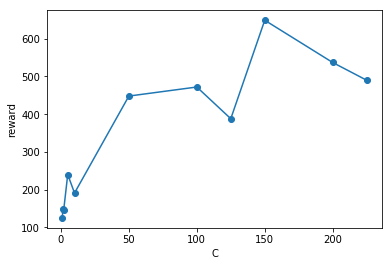

In [62]:
import matplotlib.pyplot as plt

cashmoney = [i for (i,a) in storerewards]
plt.plot(cs,cashmoney,'o-')
plt.xlabel("C")
plt.ylabel("reward")
plt.show()

In [63]:
# now let's compare the performance of different computation times (AND C)

storetstates = []
storetactions = []
storetrewards = []
times = [0.0001,0.001,0.01,0.1,0.5,1.,1.5,2.0]

for t in times:
    print("Computation time = ", t)
    
    # Initialize the tamagotchi
    tama = Tamagotchi()
    game = Tamagotchi_Game()

    tree = MCTS(tama, game, time=t, C=150, max_moves = 100)

    action_seq = []
    state = tuple(tama)
    
    while len(action_seq) <= 1000 and not game.unpack(state).is_dead: # play for a certain amount of time (better rule?)

        tree.update(state)
        action = tree.get_play()
        action_seq.append(action)
        print("Action %i: taking action %s."% (len(action_seq),action))

        state = game.next_state(state,action)
#         if len(action_seq) % 10 == 0:
#             print("\nNumber of actions taken: ",len(action_seq))
#             print("Reward so far: ",game.reward(tree.states))
#             print("Tama state:")
#             game.unpack(state).print_tama()
    
    storetstates.append([tree.states])
    storetactions.append([action_seq])
    storetrewards.append(game.reward(tree.states))
    game.unpack(state).print_tama()

Computation time =  0.0001
Action 1: taking action play.
Action 2: taking action store.
Action 3: taking action snack.
Action 4: taking action nothing.
Action 5: taking action play.
Action 6: taking action play.
Action 7: taking action play.
Action 8: taking action play.
Action 9: taking action play.
Action 10: taking action store.
Action 11: taking action clean.
Action 12: taking action clean.
Action 13: taking action snack.
Action 14: taking action clean.
Action 15: taking action nothing.
Action 16: taking action store.
Action 17: taking action coffee.
Action 18: taking action nothing.
Action 19: taking action nothing.
Action 20: taking action nothing.
Action 21: taking action play.
Action 22: taking action store.
Action 23: taking action nothing.
Action 24: taking action store.
Action 25: taking action coffee.
Action 26: taking action nothing.
Action 27: taking action play.
Action 28: taking action store.
Action 29: taking action snack.
Action 30: taking action nothing.
Action 31: t

Action 7: taking action nothing.
Action 8: taking action nothing.
Action 9: taking action nothing.
Action 10: taking action play.
Action 11: taking action store.
Action 12: taking action snack.
Action 13: taking action snack.
Action 14: taking action snack.
Action 15: taking action nothing.
Action 16: taking action play.
Action 17: taking action nothing.
Action 18: taking action play.
Action 19: taking action play.
Action 20: taking action store.
Action 21: taking action clean.
Action 22: taking action snack.
Action 23: taking action clean.
Action 24: taking action nothing.
Action 25: taking action nothing.
Action 26: taking action play.
Action 27: taking action store.
Action 28: taking action snack.
Action 29: taking action coffee.
Action 30: taking action nothing.
Action 31: taking action play.
Action 32: taking action store.
Action 33: taking action snack.
Action 34: taking action nothing.
Action 35: taking action store.
Action 36: taking action nothing.
Action 37: taking action pla

Action 121: taking action play.
Action 122: taking action play.
Action 123: taking action play.
Action 124: taking action nothing.
Action 125: taking action nothing.
Action 126: taking action store.
Action 127: taking action medicine.
Action 128: taking action medicine.
Action 129: taking action snack.
Action 130: taking action snack.
Action 131: taking action nothing.
Action 132: taking action play.
Action 133: taking action play.
Action 134: taking action play.
Action 135: taking action play.
Action 136: taking action play.
Action 137: taking action store.
Action 138: taking action snack.
Action 139: taking action medicine.
Action 140: taking action snack.
Action 141: taking action snack.
Action 142: taking action snack.
Action 143: taking action nothing.
Action 144: taking action nothing.
Action 145: taking action store.
Action 146: taking action nothing.
Action 147: taking action play.
Action 148: taking action play.
Action 149: taking action play.
Action 150: taking action play.
A

Action 84: taking action nothing.
Action 85: taking action play.
Action 86: taking action play.
Action 87: taking action nothing.
Action 88: taking action nothing.
Action 89: taking action play.
Action 90: taking action store.
Action 91: taking action medicine.
Action 92: taking action medicine.
Action 93: taking action snack.
Action 94: taking action snack.
Action 95: taking action snack.
Action 96: taking action medicine.
Action 97: taking action medicine.
Action 98: taking action nothing.
Action 99: taking action play.
Action 100: taking action play.
Action 101: taking action play.
Action 102: taking action play.
Action 103: taking action play.
Action 104: taking action play.
Action 105: taking action play.
Action 106: taking action nothing.
Action 107: taking action play.
Action 108: taking action play.
Action 109: taking action play.
Action 110: taking action store.
Action 111: taking action snack.
Action 112: taking action snack.
Action 113: taking action snack.
Action 114: takin

Action 332: taking action snack.
Action 333: taking action snack.
Action 334: taking action medicine.
Action 335: taking action snack.
Action 336: taking action medicine.
Action 337: taking action nothing.
Action 338: taking action play.
Action 339: taking action play.
Action 340: taking action nothing.
Action 341: taking action play.
Action 342: taking action play.
Action 343: taking action store.
Action 344: taking action snack.
Action 345: taking action snack.
Action 346: taking action medicine.
Action 347: taking action snack.
Action 348: taking action nothing.
Action 349: taking action play.
Action 350: taking action play.
Action 351: taking action play.
Action 352: taking action play.
Action 353: taking action play.
Action 354: taking action nothing.
Action 355: taking action play.
Action 356: taking action nothing.
Action 357: taking action play.
Action 358: taking action store.
Action 359: taking action snack.
Action 360: taking action medicine.
Action 361: taking action snack.

Action 28: taking action play.
Action 29: taking action play.
Action 30: taking action nothing.
Action 31: taking action play.
Action 32: taking action play.
Action 33: taking action nothing.
Action 34: taking action play.
Action 35: taking action play.
Action 36: taking action play.
Action 37: taking action play.
Action 38: taking action play.
Action 39: taking action play.
Action 40: taking action nothing.
Action 41: taking action play.
Action 42: taking action store.
Action 43: taking action snack.
Action 44: taking action snack.
Action 45: taking action medicine.
Action 46: taking action snack.
Action 47: taking action snack.
Action 48: taking action medicine.
Action 49: taking action snack.
Action 50: taking action nothing.
Action 51: taking action play.
Action 52: taking action play.
Action 53: taking action play.
Action 54: taking action play.
Action 55: taking action play.
Action 56: taking action nothing.
Action 57: taking action nothing.
Action 58: taking action play.
Action 

Action 277: taking action snack.
Action 278: taking action medicine.
Action 279: taking action snack.
Action 280: taking action medicine.
Action 281: taking action snack.
Action 282: taking action snack.
Action 283: taking action snack.
Action 284: taking action nothing.
Action 285: taking action play.
Action 286: taking action play.
Action 287: taking action play.
Action 288: taking action play.
Action 289: taking action play.
Action 290: taking action nothing.
Action 291: taking action play.
Action 292: taking action play.
Action 293: taking action play.
Action 294: taking action play.
Action 295: taking action store.
Action 296: taking action medicine.
Action 297: taking action snack.
Action 298: taking action medicine.
Action 299: taking action snack.
Action 300: taking action snack.
Action 301: taking action medicine.
Action 302: taking action snack.
Action 303: taking action nothing.
Action 304: taking action nothing.
Action 305: taking action play.
Action 306: taking action play

Action 524: taking action snack.
Action 525: taking action medicine.
Action 526: taking action snack.
Action 527: taking action medicine.
Action 528: taking action snack.
Action 529: taking action nothing.
Action 530: taking action play.
Action 531: taking action store.
Action 532: taking action snack.
Action 533: taking action nothing.
Action 534: taking action play.
Action 535: taking action play.
Action 536: taking action play.
Action 537: taking action play.
Action 538: taking action play.
Action 539: taking action play.
Action 540: taking action play.
Action 541: taking action store.
Action 542: taking action snack.
Action 543: taking action medicine.
Action 544: taking action snack.
Action 545: taking action medicine.
Action 546: taking action snack.
Action 547: taking action snack.
Action 548: taking action nothing.
Action 549: taking action play.
Action 550: taking action play.
Action 551: taking action play.
Action 552: taking action play.
Action 553: taking action play.
Actio

Action 771: taking action snack.
Action 772: taking action snack.
Action 773: taking action nothing.
Action 774: taking action play.
Action 775: taking action play.
Action 776: taking action play.
Action 777: taking action play.
Action 778: taking action play.
Action 779: taking action play.
Action 780: taking action store.
Action 781: taking action medicine.
Action 782: taking action snack.
Action 783: taking action snack.
Action 784: taking action medicine.
Action 785: taking action snack.
Action 786: taking action nothing.
Action 787: taking action play.
Action 788: taking action play.
Action 789: taking action play.
Action 790: taking action play.
Action 791: taking action play.
Action 792: taking action play.
Action 793: taking action play.
Action 794: taking action store.
Action 795: taking action snack.
Action 796: taking action medicine.
Action 797: taking action snack.
Action 798: taking action medicine.
Action 799: taking action snack.
Action 800: taking action snack.
Action 

Action 10: taking action play.
Action 11: taking action nothing.
Action 12: taking action play.
Action 13: taking action play.
Action 14: taking action store.
Action 15: taking action snack.
Action 16: taking action clean.
Action 17: taking action snack.
Action 18: taking action snack.
Action 19: taking action nothing.
Action 20: taking action nothing.
Action 21: taking action play.
Action 22: taking action play.
Action 23: taking action store.
Action 24: taking action snack.
Action 25: taking action clean.
Action 26: taking action nothing.
Action 27: taking action play.
Action 28: taking action store.
Action 29: taking action snack.
Action 30: taking action nothing.
Action 31: taking action play.
Action 32: taking action play.
Action 33: taking action play.
Action 34: taking action play.
Action 35: taking action play.
Action 36: taking action play.
Action 37: taking action nothing.
Action 38: taking action play.
Action 39: taking action nothing.
Action 40: taking action play.
Action 4

Action 260: taking action store.
Action 261: taking action snack.
Action 262: taking action medicine.
Action 263: taking action snack.
Action 264: taking action medicine.
Action 265: taking action snack.
Action 266: taking action nothing.
Action 267: taking action play.
Action 268: taking action play.
Action 269: taking action store.
Action 270: taking action snack.
Action 271: taking action medicine.
Action 272: taking action medicine.
Action 273: taking action snack.
Action 274: taking action snack.
Action 275: taking action nothing.
Action 276: taking action play.
Action 277: taking action nothing.
Action 278: taking action play.
Action 279: taking action play.
Action 280: taking action play.
Action 281: taking action play.
Action 282: taking action play.
Action 283: taking action play.
Action 284: taking action store.
Action 285: taking action snack.
Action 286: taking action snack.
Action 287: taking action medicine.
Action 288: taking action snack.
Action 289: taking action medic

Action 508: taking action play.
Action 509: taking action play.
Action 510: taking action play.
Action 511: taking action play.
Action 512: taking action play.
Action 513: taking action play.
Action 514: taking action play.
Action 515: taking action play.
Action 516: taking action play.
Action 517: taking action store.
Action 518: taking action snack.
Action 519: taking action medicine.
Action 520: taking action snack.
Action 521: taking action medicine.
Action 522: taking action snack.
Action 523: taking action snack.
Action 524: taking action nothing.
Action 525: taking action play.
Action 526: taking action play.
Action 527: taking action play.
Action 528: taking action play.
Action 529: taking action play.
Action 530: taking action nothing.
Action 531: taking action store.
Action 532: taking action snack.
Action 533: taking action medicine.
Action 534: taking action snack.
Action 535: taking action medicine.
Action 536: taking action snack.
Action 537: taking action snack.
Action 5

Action 756: taking action snack.
Action 757: taking action nothing.
Action 758: taking action play.
Action 759: taking action play.
Action 760: taking action play.
Action 761: taking action play.
Action 762: taking action store.
Action 763: taking action snack.
Action 764: taking action medicine.
Action 765: taking action snack.
Action 766: taking action snack.
Action 767: taking action nothing.
Action 768: taking action play.
Action 769: taking action play.
Action 770: taking action play.
Action 771: taking action play.
Action 772: taking action play.
Action 773: taking action store.
Action 774: taking action medicine.
Action 775: taking action snack.
Action 776: taking action medicine.
Action 777: taking action nothing.
Action 778: taking action play.
Action 779: taking action play.
Action 780: taking action play.
Action 781: taking action play.
Action 782: taking action nothing.
Action 783: taking action play.
Action 784: taking action play.
Action 785: taking action store.
Action 7

Action 1: taking action play.
Action 2: taking action nothing.
Action 3: taking action store.
Action 4: taking action snack.
Action 5: taking action nothing.
Action 6: taking action play.
Action 7: taking action play.
Action 8: taking action nothing.
Action 9: taking action nothing.
Action 10: taking action play.
Action 11: taking action play.
Action 12: taking action store.
Action 13: taking action snack.
Action 14: taking action snack.
Action 15: taking action medicine.
Action 16: taking action snack.
Action 17: taking action nothing.
Action 18: taking action nothing.
Action 19: taking action play.
Action 20: taking action play.
Action 21: taking action store.
Action 22: taking action snack.
Action 23: taking action snack.
Action 24: taking action nothing.
Action 25: taking action play.
Action 26: taking action play.
Action 27: taking action play.
Action 28: taking action play.
Action 29: taking action play.
Action 30: taking action nothing.
Action 31: taking action store.
Action 32:

KeyboardInterrupt: 

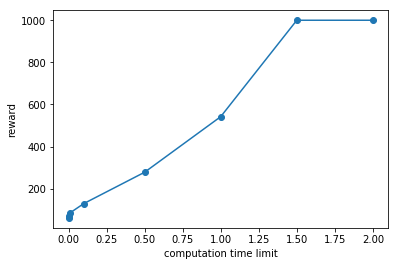

In [65]:
times = [0.0001,0.001,0.01,0.1,0.5,1.,1.5,2.0]
cashtmoney = [i for (i,a) in storetrewards]
plt.plot(times,cashtmoney,'o-')
plt.xlabel("computation time limit")
plt.ylabel("reward")
plt.show()